# Common part

- Dataset 1 (general): [link](https://mavenanalytics.io/data-playground)
- Dataset 2 (sentiment analysis): [link](https://huggingface.co/datasets/kcimc/NUFORC/tree/main)

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

tqdm.pandas()  # Registers the progress_apply method

COLOR = '#727272'
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['figure.dpi'] = 200
output_path_plt = "../images/"
output_path_bokeh = "../templates/"

df = pd.read_csv(
    "../../../ufo_sightings_scrubbed.csv",
    low_memory=False
)

# Drop unnecessary columns
# df.drop(columns=['city', 'state', 'country', 'duration (hours/min)'], inplace=True)
df.drop(columns=['duration (hours/min)'], inplace=True)

# Rename columns
df.rename(columns={'duration (seconds)': 'duration'}, inplace=True)

# Fix missing states
df.loc[df['country'].isna() & df['state'].notna(), 'country'] = 'us'
df.dropna(subset=['country', 'state'], how='all', inplace=True)

# Fix dates
df['datetime'] = pd.to_datetime(df['datetime'])
df['date posted'] = pd.to_datetime(df['date posted'])

# Fix numbers
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['duration'].dropna(inplace=True)

# Swap datetime and date posted if datetime is greater than date posted
mask = df['datetime'].dt.date > df['date posted'].dt.date
df.loc[mask, ['datetime', 'date posted']] = df.loc[mask, ['date posted', 'datetime']].values

# Shape mapping
shape_mappings = {
    'cylinder': 'cylinder',
    'light': 'flash',
    'circle': 'disk',
    'sphere': 'sphere',
    'disk': 'disk',
    'fireball': 'fireball',
    'unknown': 'unknown',
    'oval': 'oval',
    'other': 'other',
    'cigar': 'cylinder',
    'rectangle': 'rectangle',
    'chevron': 'chevron',
    'triangle': 'triangle',
    'formation': 'formation',
    'delta': 'triangle',
    'changing': 'changing',
    'egg': 'oval',
    'diamond': 'diamond',
    'flash': 'flash',
    'teardrop': 'teardrop',
    'cone': 'cone',
    'cross': 'cross',
    'pyramid': 'other',
    'round': 'disk',
    'crescent': 'changing',
    'flare': 'flash',
    'hexagon': 'other',
    'dome': 'other',
    'changed': 'changing',
    np.nan: 'unknown'
}

df['shape'] = df['shape'].str.lower().map(shape_mappings)

# Remove incomplete year (2014)
df = df[df['datetime'].dt.year != 2014]

# Part 2 - Emotional analysis

5. Visualizations
   - Explain the visualizations you've chosen.
   - Why are they right for the story you want to tell?

We're going to focus on a specific aspect of the UFO sighting: the **emotions** of those who claim to have experienced them. In other words, we decided to use the tools available to us through this course to extract and visualize *one of the biggest factors* that influence this phenomenon.

The reason? Deep down we know these sightings often feel arbitrary and depend heavily on what the individual says they saw. Most of the time, this is where methodology struggles the most — and it's **what fuels pseudo-scientific theories**.

In order to conduct [emotional analysis](https://en.wikipedia.org/wiki/Sentiment_analysis), a tool we will use is certainly [**NLP**](https://en.wikipedia.org/wiki/Natural_language_processing) (Natural Language Processing), which includes all sorts of techniques that, by leveraging AI, can estimate the *emotion* and/or the *sentiment* in a block of text. The difference between the two is that the first can include as many *feelings* as we want (happy, sad, *grief-stricken*, etc.), while the other typically corresponds to a *positive*, *negative*, or *neutral* mark.

For our objective, we definitely needed a **variant to the [dataset 1](#common-part)**. Even though it had great and clear sanitization across the different *columns*, it fell short in the *comments* column due to a **very limited amount of characters**. 

We found [another extraction](https://huggingface.co/datasets/kcimc/NUFORC/tree/main) from the NUFORC website, which includes the full text of the *comments*. It's just one of the many scrapings out there. All of them are slightly differnt but based on the same source. You’ll find an overview of its characteristics [right after](#dataset-overview) the import process.

In [186]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_csv(
    "../../../nuforc_bool.csv",
).rename(columns={
    'Sighting': 'Row ID',
    'Text': 'Comments',
    'Occurred': 'Datetime',
    'Duration': 'Duration (text)',
}).set_index('Row ID')

df.drop(columns=['Summary', 'Posted'], inplace=True)
df.rename(columns={ 'Reported': 'Date Posted' }, inplace=True)
df['Shape'] = df['Shape'].str.lower().map(shape_mappings)

# Convert headings to lowercase
df.columns = df.columns.str.lower()

# Fix dates
timezone_mapping = {
    "Pacific": "PST",    
    "Eastern": "EST",    
    "Central": "CST",    
    "Mountain": "MST",   
    "UTC": "UTC",
    "GMT": "GMT",
    "Local": "",  # Remove 'local' to keep datetime naive
}

def map_timezone(s):
    if pd.isna(s):
        return s
    # Extract last word
    last_word = re.findall(r'\b(\w+)$', s)
    if last_word and last_word[0] in timezone_mapping:
        # Replace last word with mapped timezone
        return re.sub(r'\b\w+$', timezone_mapping[last_word[0]], s)
    return s

# TODO there are outlier dates! e.g. 1639
df['datetime'] = pd.to_datetime(df['datetime'].apply(map_timezone), errors='coerce')
df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))

# Extract duration in seconds using regex
# TODO use better technique
def extract_duration(duration):
    if not isinstance(duration, str):
        return np.nan
    # Match hours (e.g., "2 hours", "1hr")
    match_hr = re.search(r'(\d+)\s*hour', duration, re.IGNORECASE)
    if match_hr:
        return int(match_hr.group(1)) * 3600
    # Match minutes (e.g., "2 min", "20minutes")
    match_min = re.search(r'(\d+)\s*min', duration, re.IGNORECASE)
    if match_min:
        return int(match_min.group(1)) * 60
    # Match seconds (e.g., "30 seconds")
    match_sec = re.search(r'(\d+)\s*sec', duration, re.IGNORECASE)
    if match_sec:
        return int(match_sec.group(1))
    return np.nan

df['duration'] = df['duration (text)'].apply(extract_duration)

# Drop unnecessary columns and NAs
df.dropna(subset=['location', 'date posted', 'datetime'], inplace=True)

df_sent = df.dropna(subset=['comments']).copy()

/var/folders/gq/c0m9vgqx2_vflttb1fnkyw1r0000gn/T/ipykernel_63107/2561801776.py:45: FutureWarning: Parsed string "2014-10-23 11:11:17 PST" included an un-recognized timezone "PST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))


## Dataset overview
After the cleaning

In [187]:
print("Number of rows:", len(df))
print("Sighting date range:", df['datetime'].min(), "to", df['datetime'].max())
print("Posted date range:", df['date posted'].min(), "to", df['date posted'].max())
print("Sighting duration range:", df['duration'].min(), "to", df['duration'].max(), "seconds (around", int(df['duration'].max() / 86400), "days!!)")
print("Median length of comments:", int(df['comments'].str.len().median()), "characters (around", int(df['comments'].str.len().median() / 280), "tweets!!)")
print("Comment length range:", int(df['comments'].str.len().min()), "to", int(df['comments'].str.len().max()), "characters (around", int(df['comments'].str.len().max() / 280), "tweets!!)")

Number of rows: 147585
Sighting date range: 1721-02-01 05:24:00 to 2023-12-20 05:30:00
Posted date range: 1995-01-01 00:00:00 to 2023-12-20 09:05:20
Sighting duration range: 0.0 to 345600.0 seconds (around 4 days!!)
Median length of comments: 682 characters (around 2 tweets!!)
Comment length range: 1 to 64550 characters (around 230 tweets!!)


## Pre-processing
In order to try out different techniques for natural language processing, an important first step is to extract a **lemmatized** column. As beneficial as it is to have long comments, some models may still have a hard time figuring out the predominant emotion or sentiment if the text is too crowded.

[Lemmatization](https://en.wikipedia.org/wiki/Lemmatization) is the process of reducing words to their base or dictionary form. With **NLTK**, we can do this using the `WordNetLemmatizer`, which helps simplify the text and reduce noise by treating different forms of a word as a single term.

In [188]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Only first time
# nltk.download('all')

df_sent = df.dropna(subset=['comments']).copy()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, max_words=None):
    if not isinstance(text, str):
        return ""
    # Remove HTML-like codes using regex (e.g., &amp;, &#39;, etc.)
    # text = re.sub(r'&[#a-zA-Z0-9]+;', ' ', text)
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Truncate if max_words is specified
    if max_words is not None:
        tokens = tokens[:max_words]
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

df_sent['lemmatized comments'] = df_sent['comments'].progress_apply(lambda x: preprocess_text(x))

  0%|          | 0/130963 [00:00<?, ?it/s]

## NLP  
There are many methods to choose from and we tried all of them. They can be summarized in:

**BoW (bag of words)**  
This approach transforms text into a vector by counting how often each word appears, without considering grammar or word order. Each document gets a score based on the presence or frequency of specific words. It's simple but can miss context and meaning.

**Transformer-based models (e.g. BERT, ROBERTA)**  
These models understand context by processing the entire sentence at once, capturing meaning and nuance in a way traditional methods can't. They require more resources but can deliver better results.

**Cherry-picking terms**  
We manually pick and find specific keywords that are strongly associated with certain emotional tones or sentiments, and use their presence or frequency to get the classification.

### Method 1: Sentiment Analysis with BoW Model (Vader)
This method is very resource-efficient, but its results aren't very useful, since 95% of the outputs are classified as neutral sentiment. Although this may actually reflect the nature of the data — most comments are simple descriptions of what was seen — the model is probably being misled by random punctuation or the excessive length of the texts.

In [193]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Tresholding for sentiment
    sentiment = max(['pos', 'neu', 'neg'], key=lambda x: scores[x])
    return sentiment

df_sent['sentiment'] = df_sent['lemmatized comments'].progress_apply(get_sentiment)

df_sent['sentiment'].value_counts()

  0%|          | 0/130963 [00:00<?, ?it/s]

sentiment
neu    130730
pos       184
neg        49
Name: count, dtype: int64

### Method 2: Sentiment Analysis with Transformer model (BERT)
This method is particularly heavy on resources and not very promising in terms of results. 

The first issue comes from the complexity of the **transformer** architecture, which processes all words in parallel and requires a lot of memory and compute. For this reason, we only conducted a test on a tiny subset of the data to keep the processing time to some *minutes* instead of hours. 

The second issue is likely due to the limitation in tokens, which is set to 512. A possible solution we didn't dig into would have been to split each comment into multiple blocks and then average the results of the algorithm.

In [194]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=1,
    truncation=True,
	max_length=512 # Truncate to 512 tokens for model limitations
)

# Sample 5000 rows for sentiment analysis because of resource limits
df_sent_sample = df_sent.sample(n=5000, random_state=42)
df_sent_sample['sentiment'] = df_sent_sample['comments'].progress_apply(
    lambda x: sentiment_pipeline(x)[0][0]['label']
)

df_sent_sample['sentiment'].value_counts()

Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

sentiment
NEGATIVE    4438
POSITIVE     562
Name: count, dtype: int64

### 🏆 Method 3: Emotional Analysis with Cherry-picking words  
This method is the **most lightweight** on resources and, at the same time, the one that led to the **most promising results** that could be extended to the whole dataset — with some important **limitations**.

The method we **handcrafted** 🍳 is based on a main keyword (e.g. *scared*), which is, for redundancy, aliased with a few others (e.g. *fear*, *worried*, ...). Then a **full-text search** is applied on the *lemmatized* comments, and a **flag** is assigned with the **main keyword** (i.e. the emotion) if *one or more* of the terms is found. As a result, a single comment can be associated with **multiple emotions**.

The limitations come mainly from the fact that the selected emotions and their correlated synonyms are, to some extent, **arbitrary**. We started with **Ekman's six basic emotions** (anger, disgust, fear, happiness, sadness, and surprise) and replaced *anger* and *disgust** with *confusion** and *curiosity*, as more relevant to our context. Also, the choice of synonyms can be considered arbitrary — we selected words that balanced the frequency in the dataset and the unlikeliness to be outliers from other parts of speech (e.g. using *glad* could unintentionally match contexts like *"I would be glad if"* rather than the gratitude emotion for the sighting).

Other limits may be due to people's spelling mistakes, or to the chosen **lemmatization** method, which might omit some relevant keywords or include irrelevant ones.

In [189]:
# Define a list of emotion-related keywords with synonyms
emotion_keywords_synonyms = {
    'scared': ['scared', 'fear', 'afraid', 'panic', 'worried'],
    'confused': ['confused', 'uncertain', 'lost', 'unsure', 'disoriented'],
    'sad': ['sad', 'unhappy', 'upset', 'gloomy', 'depressed'],
    'surprised': ['surprised', 'shocked', 'stunned', 'speechless', 'taken-aback'],
    'joy': ['joy', 'excited', 'cheerful', 'enthusiastic', 'thrilled'],
    'curious': ['curious', 'interested', 'alert', 'intrigued', 'exploring'],
}
emotion_keywords = list(emotion_keywords_synonyms.keys())

# Create a column for each emotion keyword (lemmatized)
for emotion, synonyms in emotion_keywords_synonyms.items():
    df_sent[emotion] = df_sent['lemmatized comments'].progress_apply(
        lambda x: any(word in x.lower() for word in synonyms) if isinstance(x, str) else False
    )

# Display the updated dataframe with the new emotion columns
df_sent[['comments'] + emotion_keywords]

# Save the updated dataframe to a CSV file for later use
df_sent.to_csv("../../../_nuforc_sent.csv")

# Count the number of rows for each emotion
df_sent[emotion_keywords].sum().sort_values(ascending=False)

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

confused     7865
scared       6346
curious      4476
surprised    3445
joy          3245
sad           833
dtype: int64

### Method 4: Emotional Analysis with Transformer model (RoBERTa)
Similarly as [before](#method-2-sentiment-analysis-with-transformer-model-bert), this method suffers from the same performance limitations due to the transformer architecture and the 512-token cap. 

However, *emotional* analysis with RoBERTa differs in that it returns a distribution over **multiple emotions rather than a single polarity**. This could, in theory, offer more nuanced insights compared to sentiment classification. 

Still, because of the longer and often noisy nature of our texts, this granularity ends up making the output less stable and very resource-heavy, especially when emotional signals are weak or mixed with descriptions.

In [195]:
from transformers import pipeline

emotion_pipeline = pipeline(
    "text-classification",
    # model="cardiffnlp/twitter-roberta-base-emotion",
    model="j-hartmann/emotion-english-distilroberta-base", 
    top_k=1,
    truncation=True,
	max_length=512 # Truncate to 512 tokens for model limitations
)

# Sample 5000 rows for emotion analysis because of resource limits
# df_sent_sample = df_sent.sample(n=5000, random_state=42).copy()
df_sent_sample['emotion'] = df_sent_sample['comments'].progress_apply(
    lambda x: emotion_pipeline(x)[0][0]['label']
)

df_sent_sample['emotion'].value_counts()

Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Visualizations (Method 3)  
Among the different methods, [the third one](#-method-3-emotional-analysis-with-cherry-picking-words) was favored because of the balance between computational efficiency and the representativeness of the dataset as a whole. It also featured a range of emotions that are interesting to explore and visualize.

### Most frequent emotions
The plot to start with has to convey the most **intuitive yet basic** information possible. For this reason, we chose to plot with **bars** the overall instances of each emotion found in the dataset. 

It's important to note that a **color coding** was defined and consistently applied across the plots that will follow, making them easy to recognize at a glance which emotion each visual element refers to.

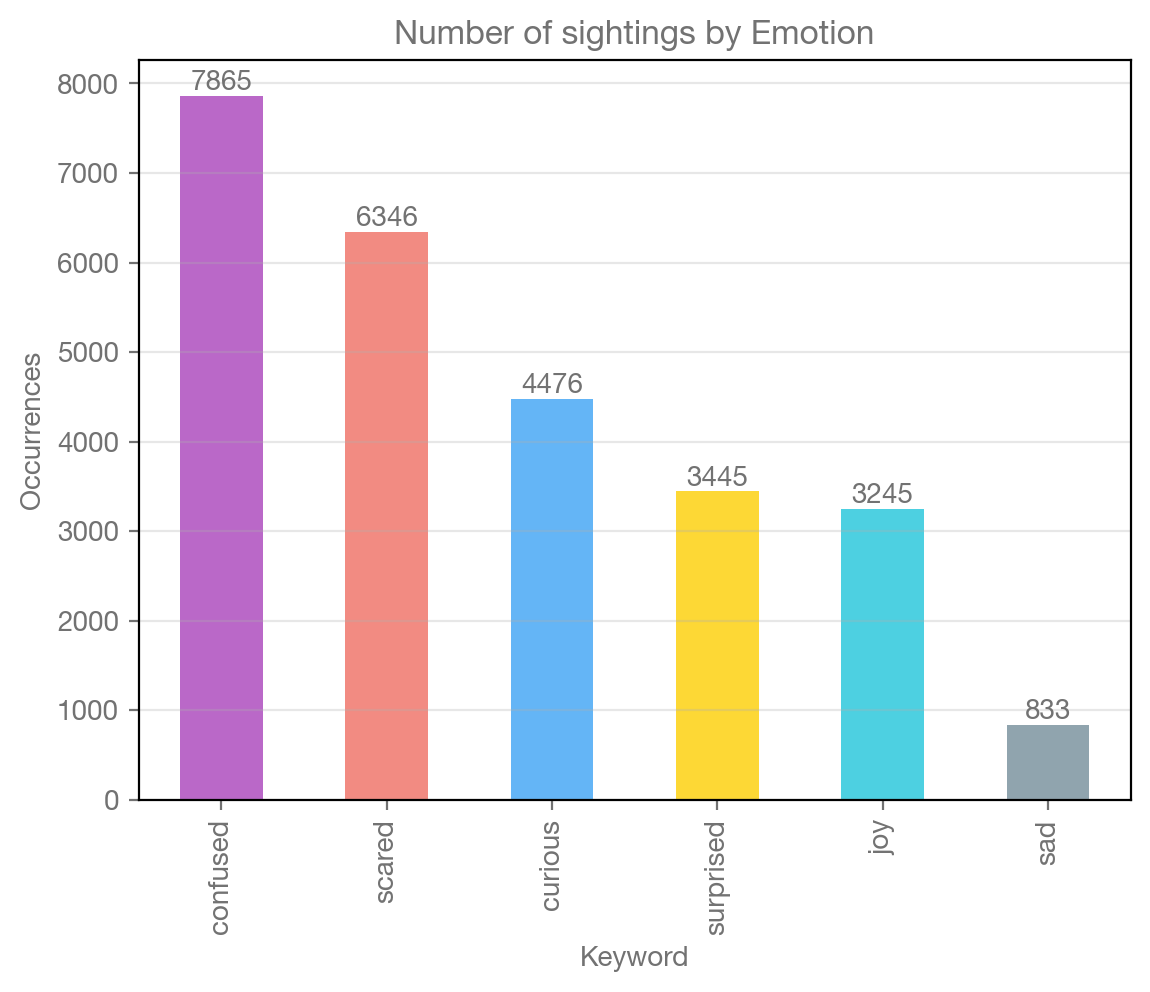

In [222]:
# ------
# Setup 
# ------

output_path_plt = "../images/fp_"
output_path_bokeh = "../templates/fp_"

df_sent = pd.read_csv("../../../_nuforc_sent.csv")
df_sent['datetime'] = pd.to_datetime(df_sent['datetime'], errors='coerce')
df_sent['date posted'] = pd.to_datetime(df_sent['date posted'])

emotion_keywords_synonyms = {
    'scared': ['scared', 'fear', 'afraid', 'panic', 'worried'],
    'confused': ['confused', 'uncertain', 'lost', 'unsure', 'disoriented'],
    'sad': ['sad', 'unhappy', 'upset', 'gloomy', 'depressed'],
    'surprised': ['surprised', 'shocked', 'stunned', 'speechless', 'taken-aback'],
    'joy': ['joy', 'excited', 'cheerful', 'enthusiastic', 'thrilled'],
    'curious': ['curious', 'interested', 'alert', 'intrigued', 'exploring'],
}
emotion_keywords = list(emotion_keywords_synonyms.keys())

# Define a color for each emotion keyword
emotion_colors = {
    emotion_keywords[0]: '#f28b82',  # pastel red for fear/scared
    emotion_keywords[1]: '#ba68c8',  # pastel purple for confusion
    emotion_keywords[2]: '#90a4ae',  # pastel blue-grey for sadness
    emotion_keywords[3]: '#fdd835',  # pastel yellow for surprise
    emotion_keywords[4]: '#4dd0e1',  # pastel teal for joy
    emotion_keywords[5]: '#64b5f6',  # pastel blue for curiosity
}

# ------
# End setup
# ------

emotion_counts = df_sent[emotion_keywords].sum().sort_values(ascending=False)
ax = emotion_counts.plot(kind="bar", color=[emotion_colors.get(emotion) for emotion in emotion_counts.index])
plt.title("Number of sightings by Emotion")
plt.xlabel("Keyword")
plt.ylabel("Occurrences")
plt.grid(axis='y', alpha=0.3)
# plt.xticks(rotation=45)

# Annotate each bar with its value
for i, v in enumerate(emotion_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.savefig(output_path_plt + 'sightings_by_emotion.png', bbox_inches='tight')

The plot tells us that the most occurring emotion is "Confused" with almost 8000 reports in our dataset. Scared, Curious, and Surprised follow, with a somewhat equal separation between them, like a staircase. Joy is slightly less frequent than Surprised, both having around 3300 occurrences. Sad is by far the least occurring, having only 833 matches.

### Emotion vs Time of the Day
Next up, we thought it would have been interesting to check whether the time of day had any influence on the emotions expressed in the reports. We therefore opted for a **subplot for each emotion**, featuring a **bar plot** covering the **0–24 hour range**.

Since the previous plot showed that the magnitude of occurrences varies significantly between emotions, we decided to make the plots share only the x-axis, not the y-axis. The goal was to highlight potential differences in the **shape** of the distributions, not in their absolute values.

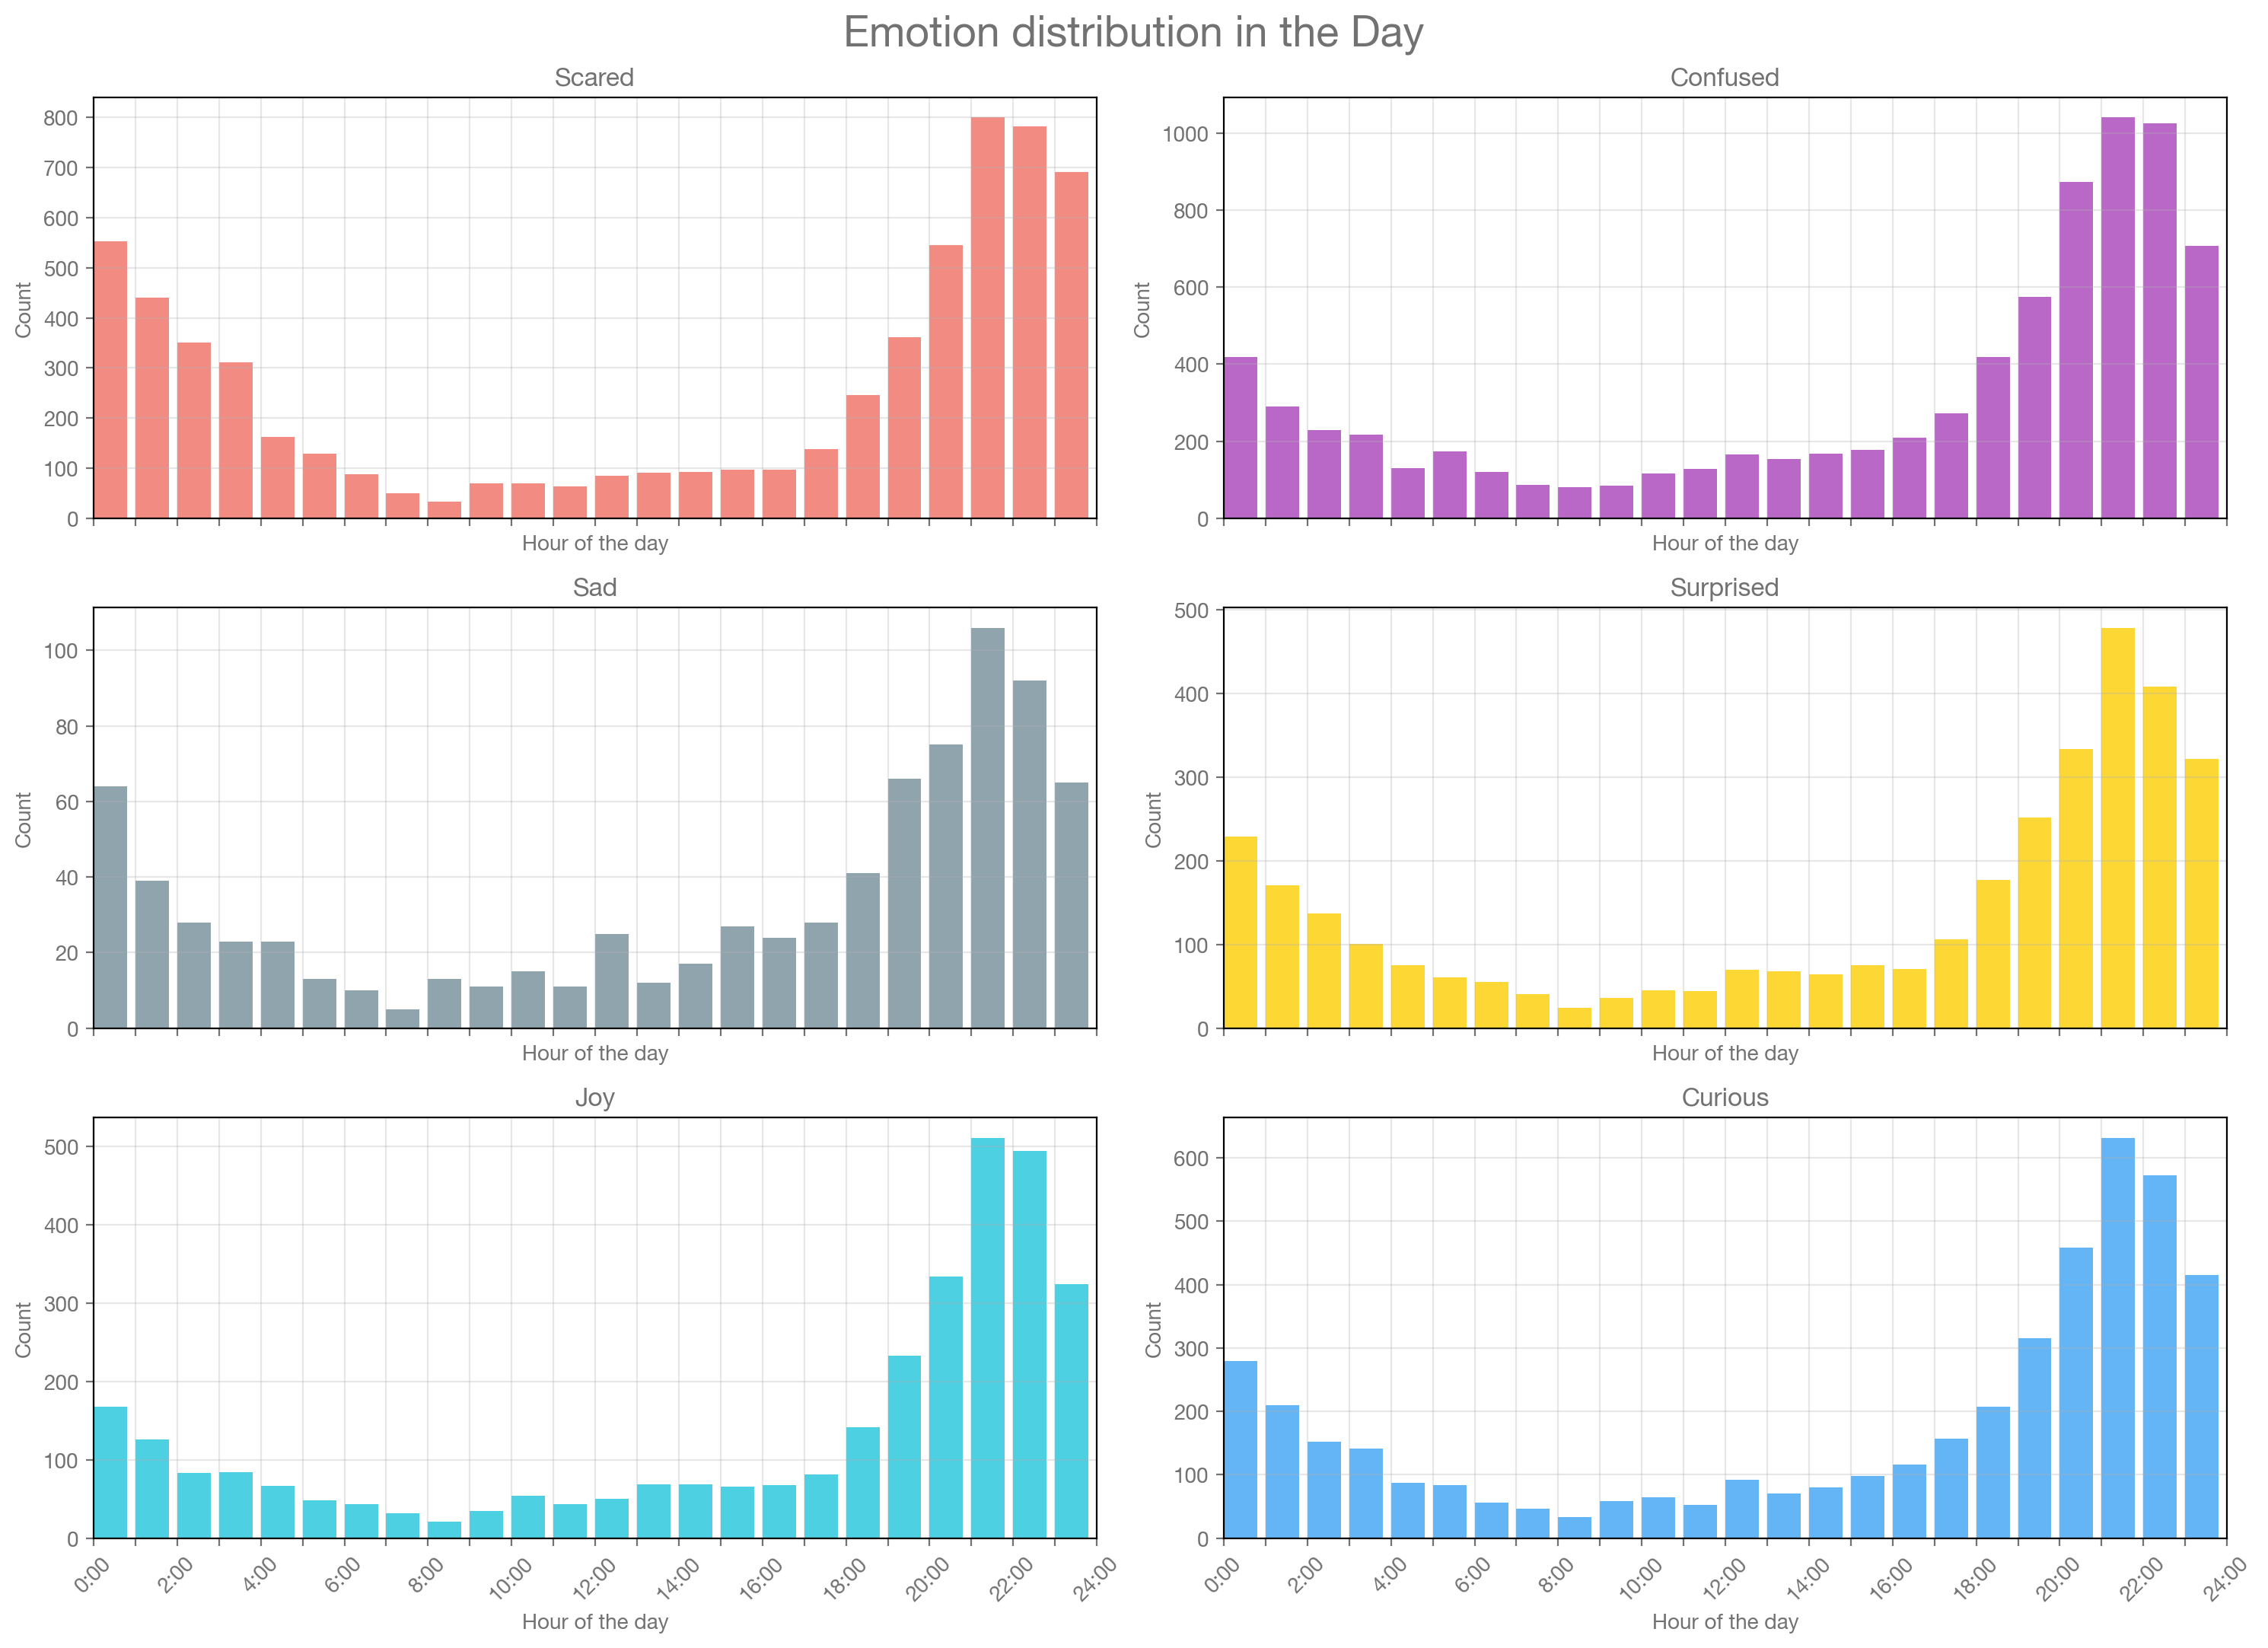

In [223]:
fig, axes = plt.subplots(3, 2, figsize=(15, 11), sharex=True)

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    
    # Count occurrences by hour
    df_emotion_count = df_emotion['datetime'].dt.hour.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['hour', 'count']
    
    ax.bar(
        df_emotion_count['hour'], 
        df_emotion_count['count'], 
        color=emotion_colors.get(e), 
        align="edge"
    )
    ax.set_xticks(range(0, 25))
    ax.set_xticklabels([f"{h}:00" if h % 2 == 0 else "" for h in range(0, 25)], rotation=45)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Hour of the day')
    ax.set_xlim(0, 24)
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

fig.suptitle('Emotion distribution in the Day', fontsize=20)
plt.tight_layout()
# plt.savefig(output_path_plt + 'emotion_distribution_in_the_day.png', bbox_inches='tight')
plt.show() # Doesn't seem relevant

There doesn't seem to be a noticeable difference between the shapes of the emotion distributions throughout the day. In other words, being late at night doesn't appear to make people more susceptible to expressing certain emotions when writing about the UFO they saw.

### Emotion vs Years
Of course, we're interested in knowing if the **trend** of UFO sightings is going **up or down throughout the years**. Since this has already been covered in another section of our project, here we focused on whether a *specific emotion* is increasing or decreasing differently compared to the others. For this, we used a setup similar to before, with subplots — but this time using **histograms**, due to the large number of ticks and our goal to observe the general trend, not exact values.

It's important to note that from this point on, regarding years, we decided to focus only on the period **1940–2023**. While the data extends further back, including everything wouldn't have added value and would clutter the visual in such a small space.

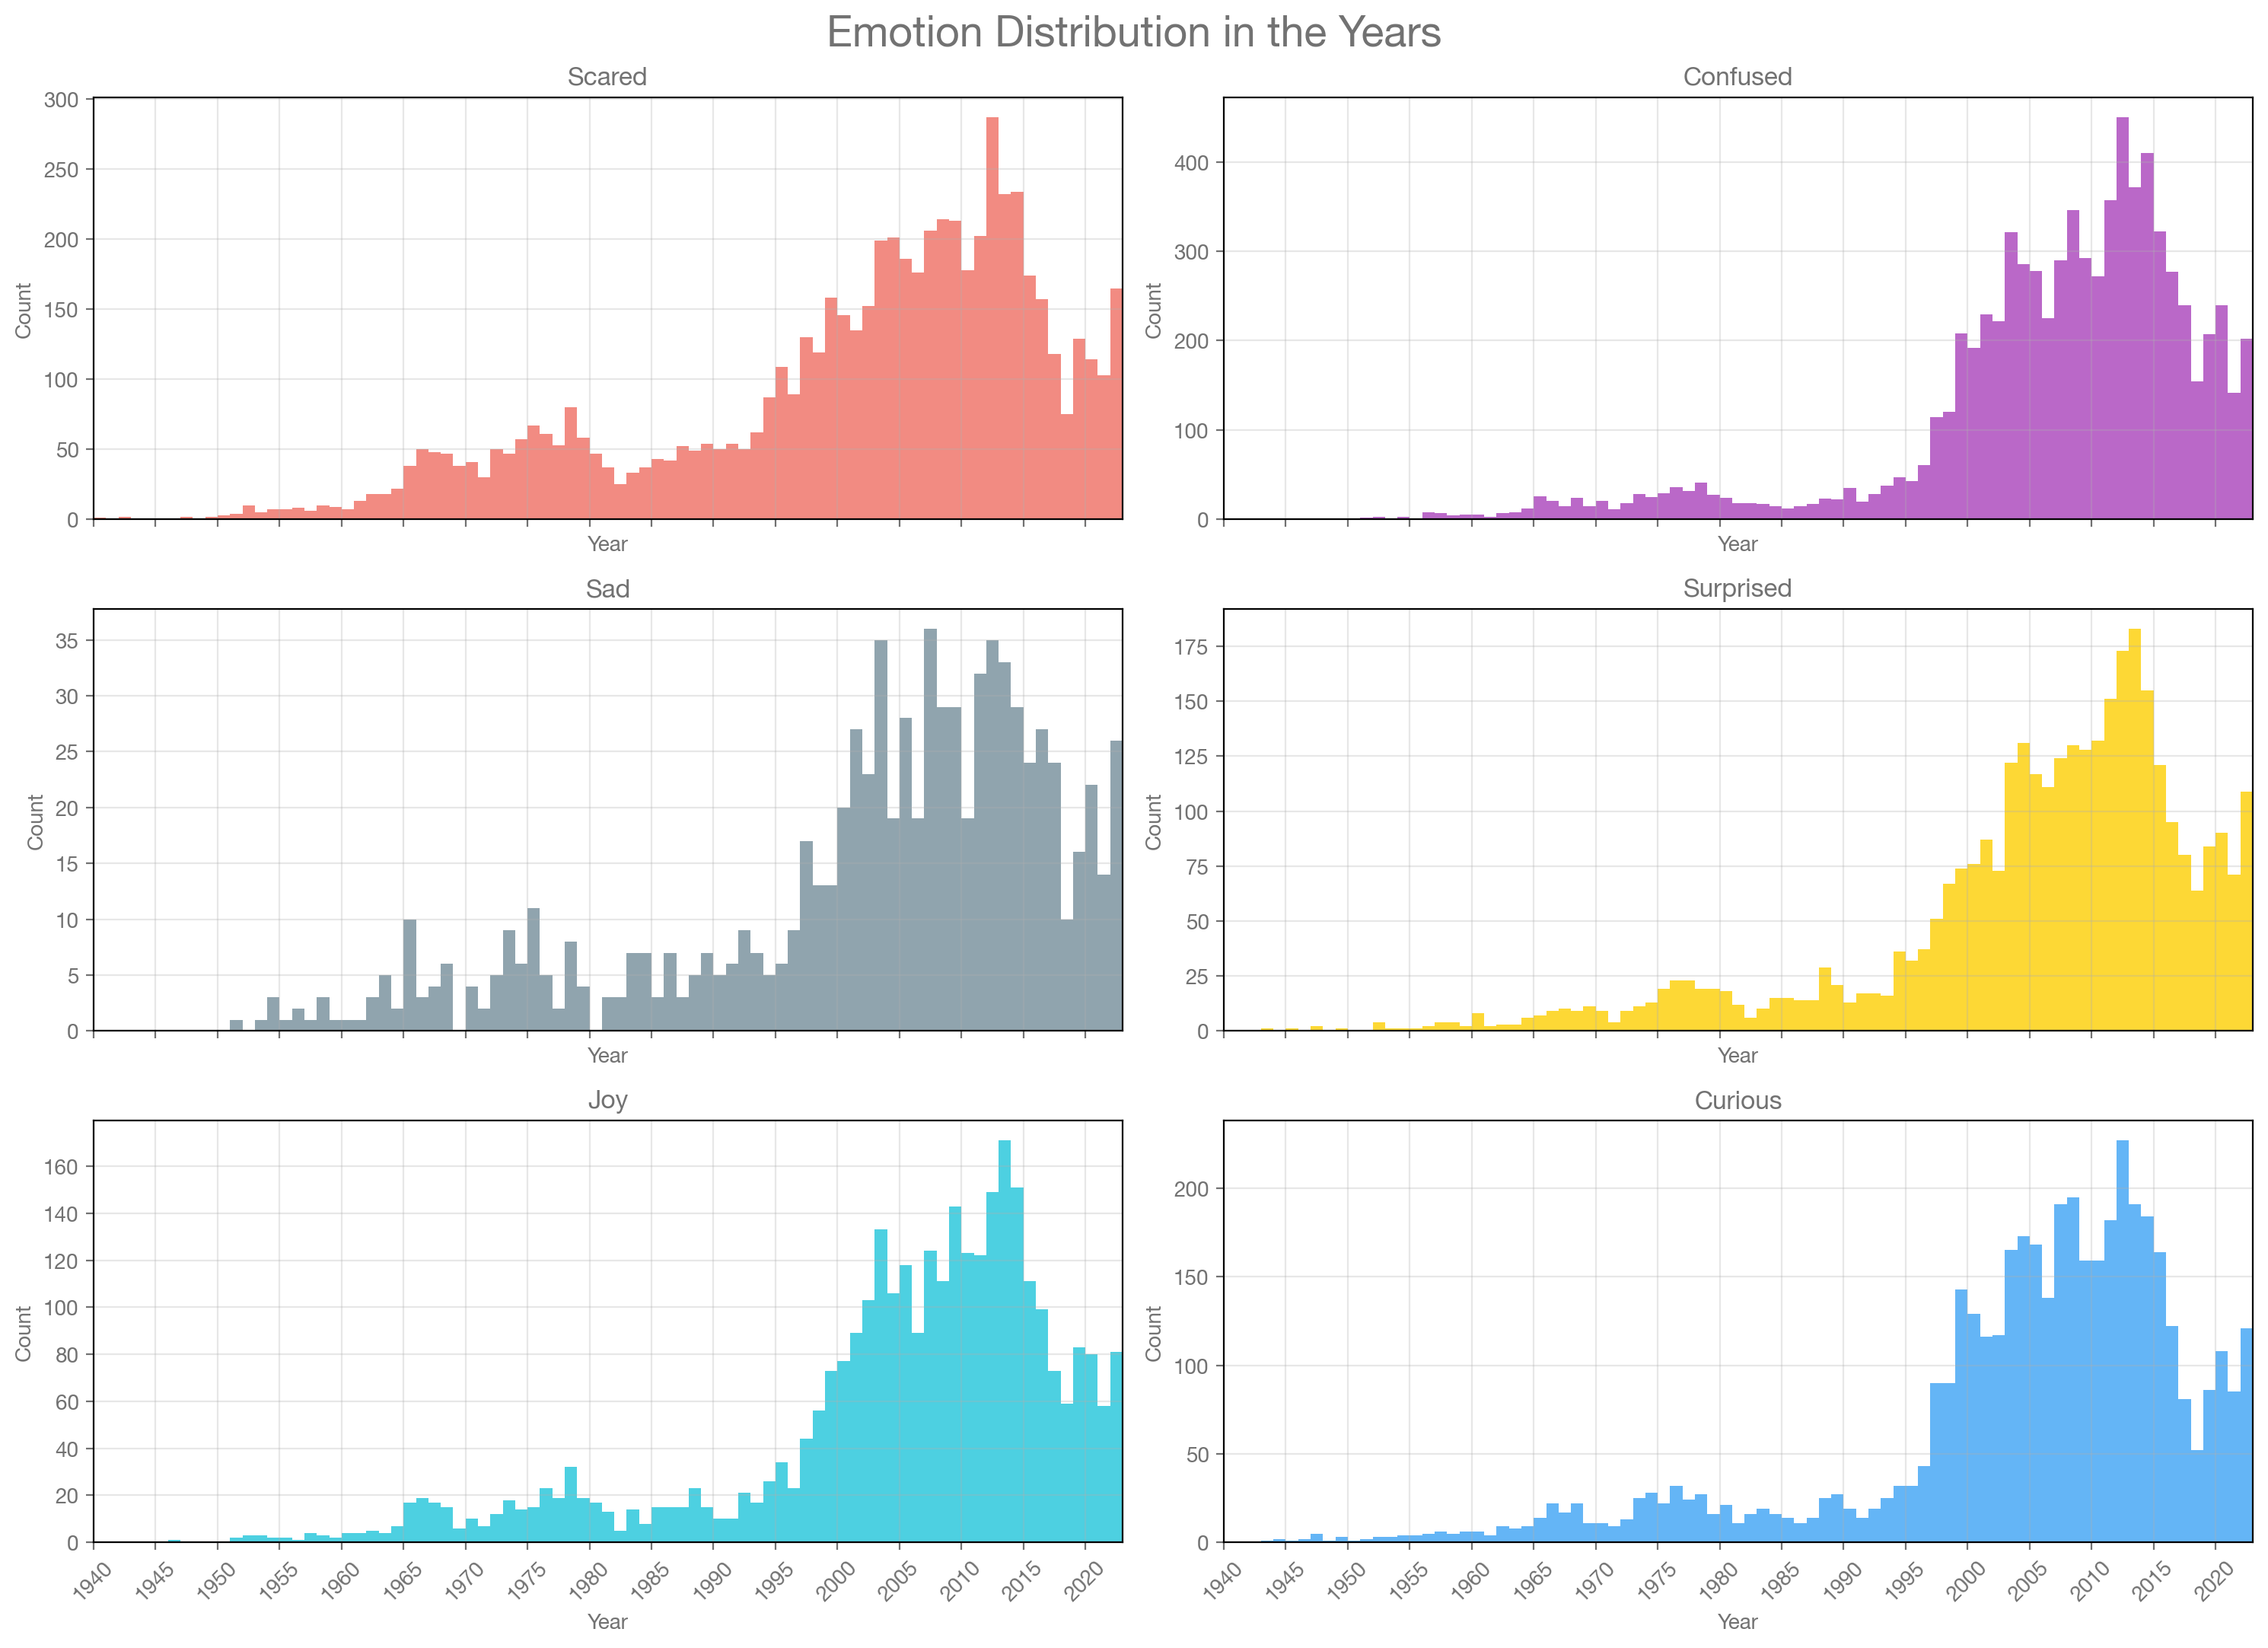

In [224]:
fig, axes = plt.subplots(3, 2, figsize=(15, 11), sharex=True)

# Define the year range
min_year = max(1940, int(df_sent['datetime'].dt.year.min()))
max_year = min(2025, int(df_sent['datetime'].dt.year.max()))
ticks = range(min_year, max_year + 1, 5)

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]

    counts, bin_edges = np.histogram(df_emotion['datetime'].dt.year.dropna(), bins=range(min_year, max_year + 2))
    ax.bar(
        bin_edges[:-1], 
        counts, 
        color=emotion_colors.get(e),
        width=np.diff(bin_edges),  # Calculate and use the width inline
        align='edge'
    )
    
    ax.set_title(e.capitalize())
    ax.set_xlabel('Year')
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=45)
    ax.set_xlim(min_year, max_year)
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

fig.suptitle('Emotion Distribution in the Years', fontsize=20)
plt.tight_layout()
plt.savefig(output_path_plt + 'sightings_by_emotion_years.png', bbox_inches='tight')

All emotions show an increase after the year 2000, likely due to the rise of social media and the ease of reporting through the website, [launched in 1995](https://nuforc.org/about-us/). However, they all peaked in 2012 before experiencing a decline. The happening of this phenomena was covered by [news](https://www.huffpost.com/entry/american-ufo-reports-down_b_2982532) but its causes still remain unknown.

Scared is the most frequent emotion during the period from 1940 to 2000. And, strangely enough, 1980 and 1969 have been the only years in the trend not to have a single Sad UFO sighting.

Since in this case something seemed to be going on differently when breaking up data by emotion, we felt it was important to give readers a more **in-depth** look at the trends. This meant **overlapping** the data in a single plot, but given the number of emotions and the wide time span, we decided to make consultation easier through a [Bokeh](http://bokeh.org) time series. This offers users an **on-demand**, **interactive**, and more **personal** way to **explore** the data.

In [225]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, RangeTool, Legend
from bokeh.layouts import column
from bokeh.io import output_notebook, output_file

output_notebook()

# Prepare data for each emotion
emotion_data = {}
for emotion in emotion_keywords:
    df_emotion = df_sent[df_sent[emotion] == True]
    df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['year', 'count']
    emotion_data[emotion] = ColumnDataSource(df_emotion_count)

# Create the main Bokeh figure
p = figure(
    title="Occurrences of Emotions per Year",
    height=300, width=650,
    x_axis_label='Year', y_axis_label='Count',
    x_range=(2000, 2023)
)

p.xaxis.ticker = list(range(1940, 2025, 1))  # one tick per year
p.xaxis.major_label_orientation = 0.785  # 45 degrees in radians

p.add_layout(Legend(), 'right')

# Create the range selection tool
select = figure(
    title="Drag the middle and edges of the selection box to change the range above.\nAlso use the legend to show or hide lines.",
    height=130, width=650, y_range=p.y_range,
    x_range=(min_year, max_year),
    tools="", toolbar_location=None,
)

renderers_p = []
renderers_select = []

# Add a line for each emotion to both plots, and keep references to renderers
for emotion in emotion_keywords:
    source = emotion_data[emotion]
    r1 = p.line(
        x='year', y='count', source=source, line_width=2,
        color=emotion_colors.get(emotion, 'blue'), alpha=0.8,
        legend_label=emotion.capitalize()
    )
    r2 = select.line(
        x='year', y='count', source=source, line_width=1,
        color=emotion_colors.get(emotion, 'blue'), alpha=0.5,
    )
    renderers_p.append(r1)
    renderers_select.append(r2)

# Set up legend
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.5
select.grid.grid_line_alpha = 0.3

# Add RangeTool
range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2
select.add_tools(range_tool)

# Synchronize visibility between main plot and select plot
# This uses a CustomJS callback to link the visibility of lines
for r1, r2 in zip(renderers_p, renderers_select):
    r1.js_link('visible', r2, 'visible')

output_file(output_path_bokeh + "sightings_by_emotion_years.html")
show(column(p, select))

Loading BokehJS ...

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


As mentioned before, the first look at the chart highlights a **spike** in all emotions in **2012**, followed by a **drop afterward**. In general, we can say that starting from **1995**, the range of emotions began to **spread more widely**, with a consistently higher frequency of *Confused* and lower frequency of *Sad*.

As expected, *Confused* is clearly the **most common emotion** across the board, especially in **2008** and again in **2012**. People mostly seem **disoriented** or **unsettled** by what they see. On the other hand, *Sad*, while being the **least occurring**, also appears to be the **most steady** throughout the entire timespan, without any particular spike.

Interestingly, *Surprised* overtakes *Curious* in **2018**, while *Curious* becomes more frequent again in **2020**. This fluctuation could indicate a **shift** in how people **perceive or describe** their experiences.

Another key observation is that *Scared* and *Curious* show the **most similar trend** between each other — even if neither overtakes the other. This could suggest that these emotions are more **situational** and tied to **specific events or phenomena**.

#### Prediction of Scared in the years  
Giving a break to the reader from comparing emotions, we deemed important to give a **positive** and **in-depth** look at the most occurring emotion, *Scared*. In particular, all of us might be interested in knowing whether the data may suggest a "**deadline**" for the negative effect of seeing a UFO. For the *visualization* part, we decided to use, as before, a line bar since it's useful to observe the **fluctuations**. On top of this, we also plotted another line featuring the *prediction* for the future years.

For the predictive part, we decided to simply apply a **polynomial regression**, using a degree that **visually best fit** the observed data, consequently giving a predicition afterwards. Polynomial regression is a method that models the relationship between the independent variable (in this case, the year) and the dependent variable (*Scared* count) as an **nth-degree polynomial curve**. A small cue for model quality is given by the **R² score** shown in the legend, which indicates how well the model explains the variance of the actual data — the closer it is to **1**, the better the fit.

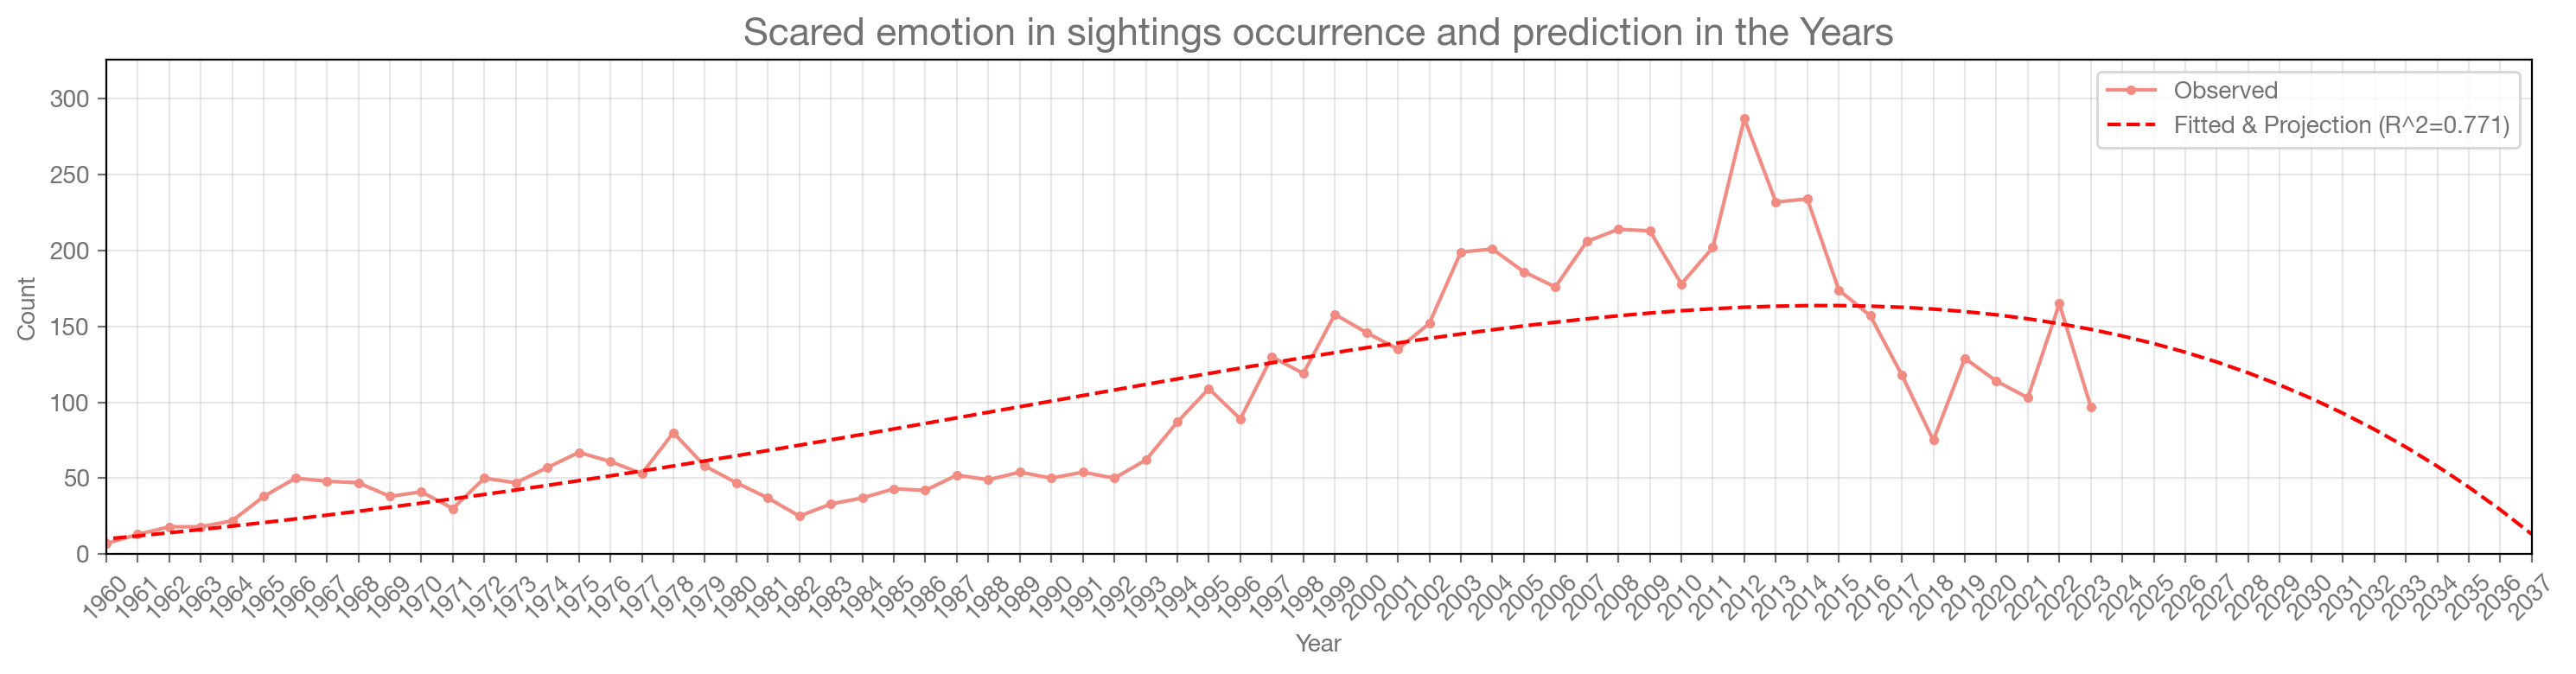

In [226]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Prepare data
df_emotion = df_sent[df_sent['scared'] == True]
df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
df_emotion_count.columns = ['year', 'count']

max_year_pred = max_year + 15

# Fit a polynomial regression (degree=2 for a curve)
X = df_emotion_count['year'].values.reshape(-1, 1)
y = df_emotion_count['count'].values
poly = PolynomialFeatures(degree=45)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)
r2 = model.score(X_poly, y)

# Predict for all years (observed + future)
all_years = np.arange(min_year, max_year_pred).reshape(-1, 1)
all_X_poly = poly.transform(all_years)
all_counts = model.predict(all_X_poly)

# Plot observed, fitted, and projection
plt.figure(figsize=(15, 4))
plt.plot(df_emotion_count['year'], df_emotion_count['count'], marker='o', markersize=3, label='Observed', color=emotion_colors.get('scared'))
plt.plot(all_years.flatten(), all_counts, 'r--', label=f'Fitted & Projection (R^2={r2:.3f})')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Scared emotion in sightings occurrence and prediction in the Years', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(min_year, max_year_pred), rotation=45)
plt.xlim(max(min_year, 1960), max_year_pred - 1)
plt.ylim(0, max(max(df_emotion_count['count']), int(all_counts.max()) * 2))
plt.tight_layout()
plt.savefig(output_path_plt + 'scared_years_projection.png', bbox_inches='tight')

Fitting a curve on the observed data, seems like that the frightening effect of sightings will be gone around 2040.

### Emotion vs Most occurring words

#### (ignore) By emotion
Apparently no relevant differences

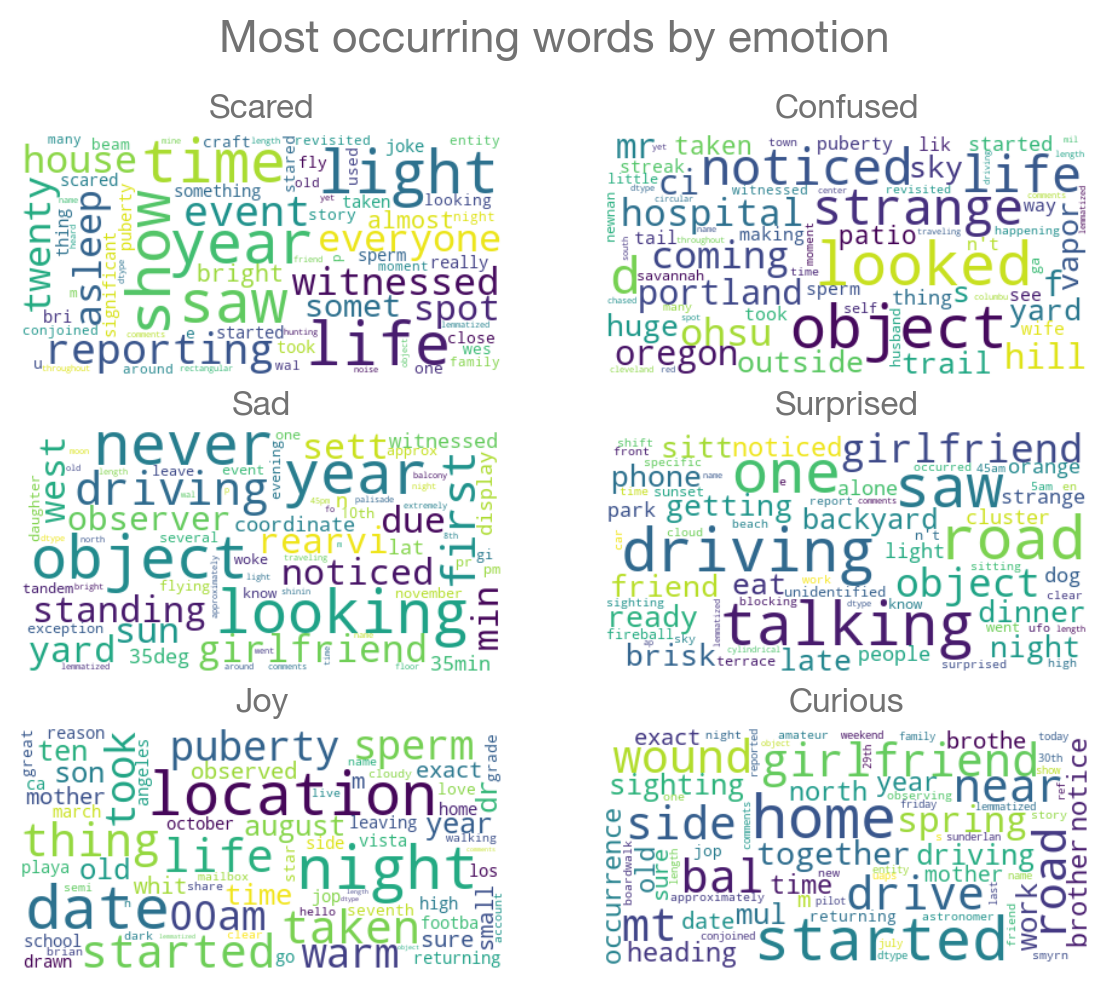

In [227]:
from wordcloud import WordCloud
 
fig, axes = plt.subplots(3, 2, figsize=(6, 5))

for ax, e in zip(axes.flatten(), emotion_keywords):
    subset = df_sent[df_sent[e] == True]
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(subset['lemmatized comments']).lower())
    ax.set_title(e.capitalize())
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

fig.suptitle('Most occurring words by emotion', fontsize=16)
plt.tight_layout()
plt.show()

#### Regardless of the emotion

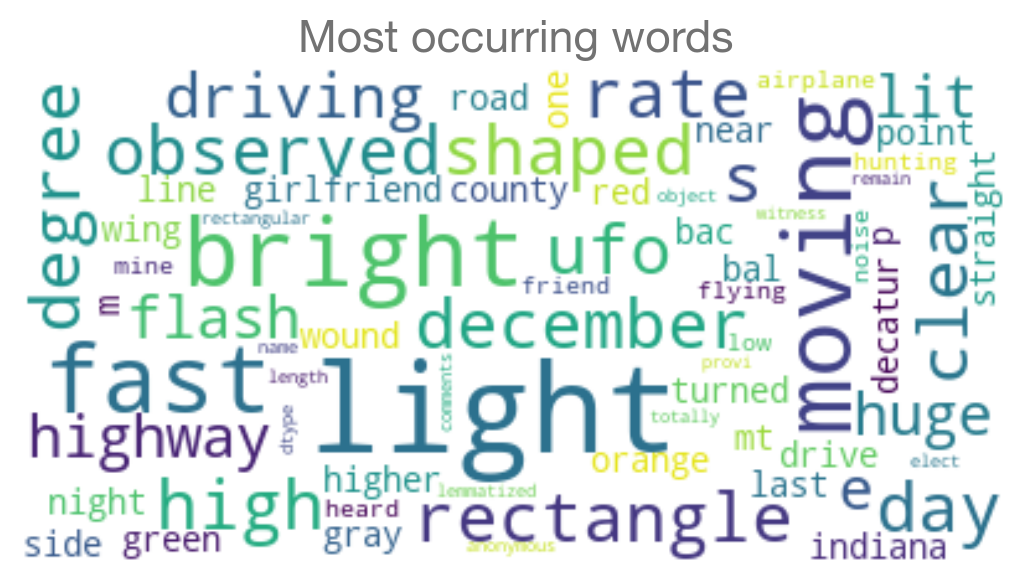

In [228]:
from wordcloud import WordCloud
 
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_sent['lemmatized comments']).lower())
plt.title('Most occurring words', fontsize=16)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### (ignore) Emotion vs Shape
Again not relevant based on emotion

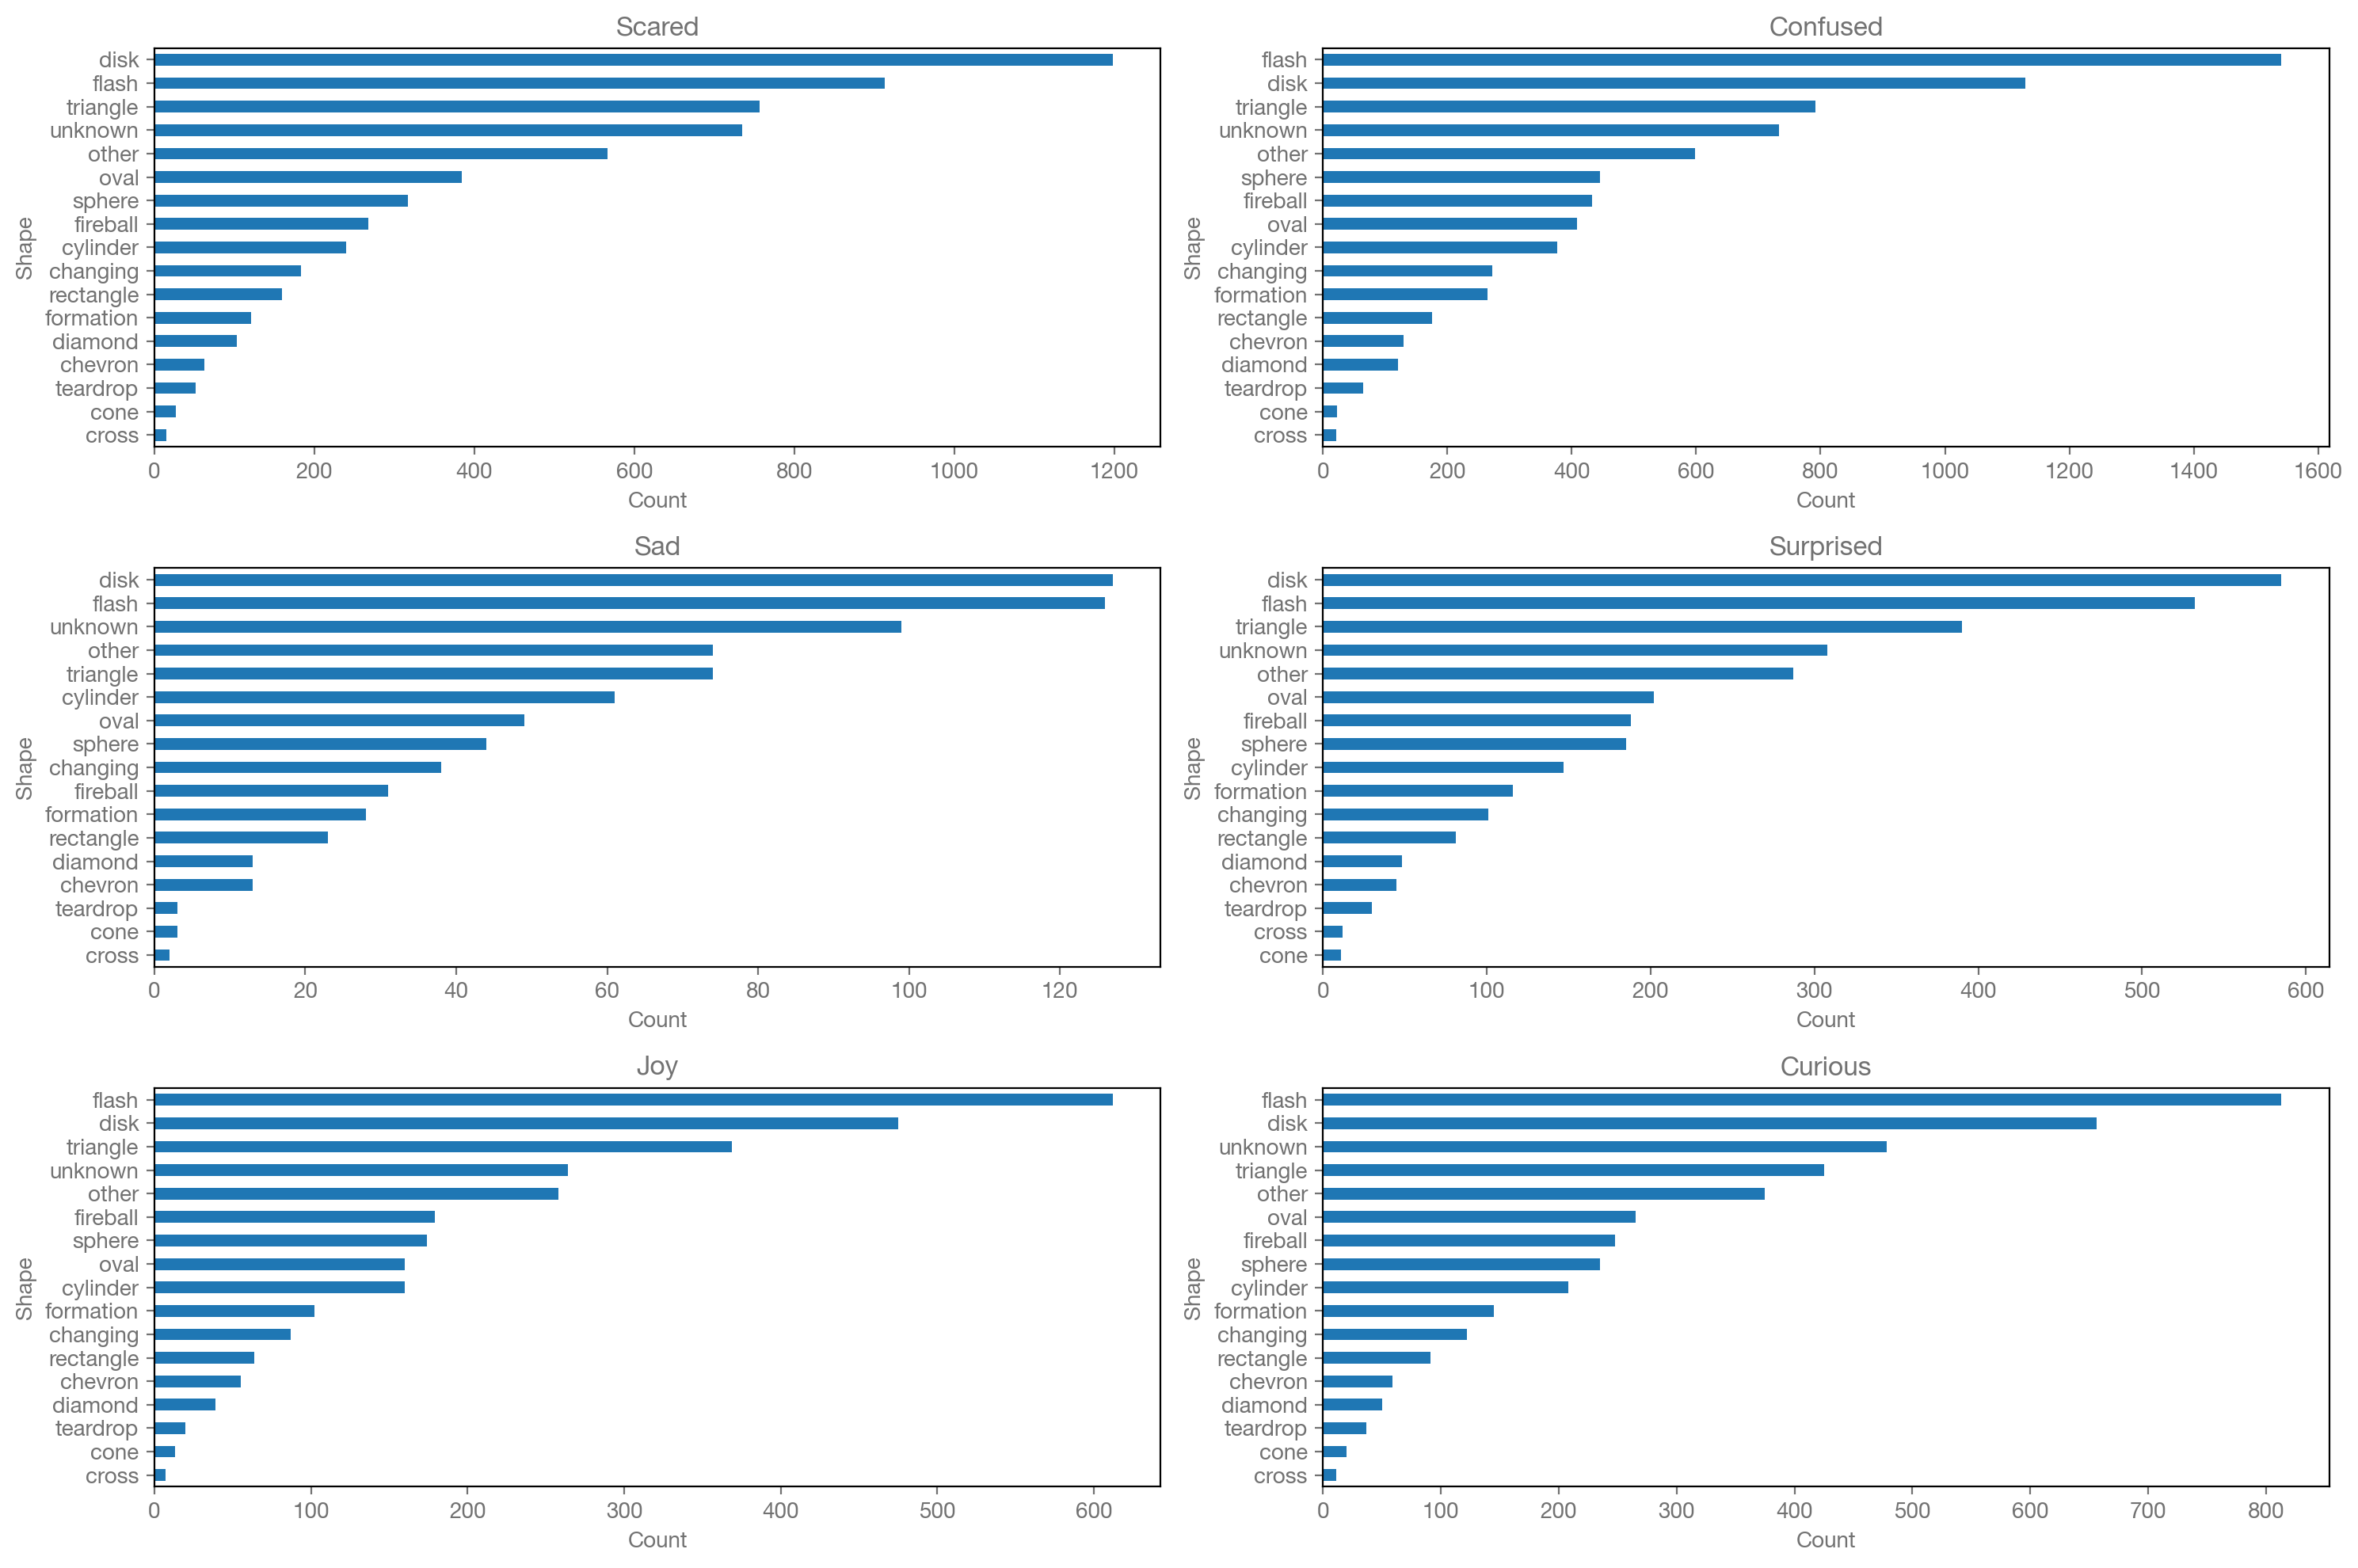

In [229]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    df_emotion.groupby('shape')['shape'].count().sort_values(ascending=True).plot(kind='barh', ax=ax)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Count')
    ax.set_ylabel('Shape')

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Emotion vs Duration

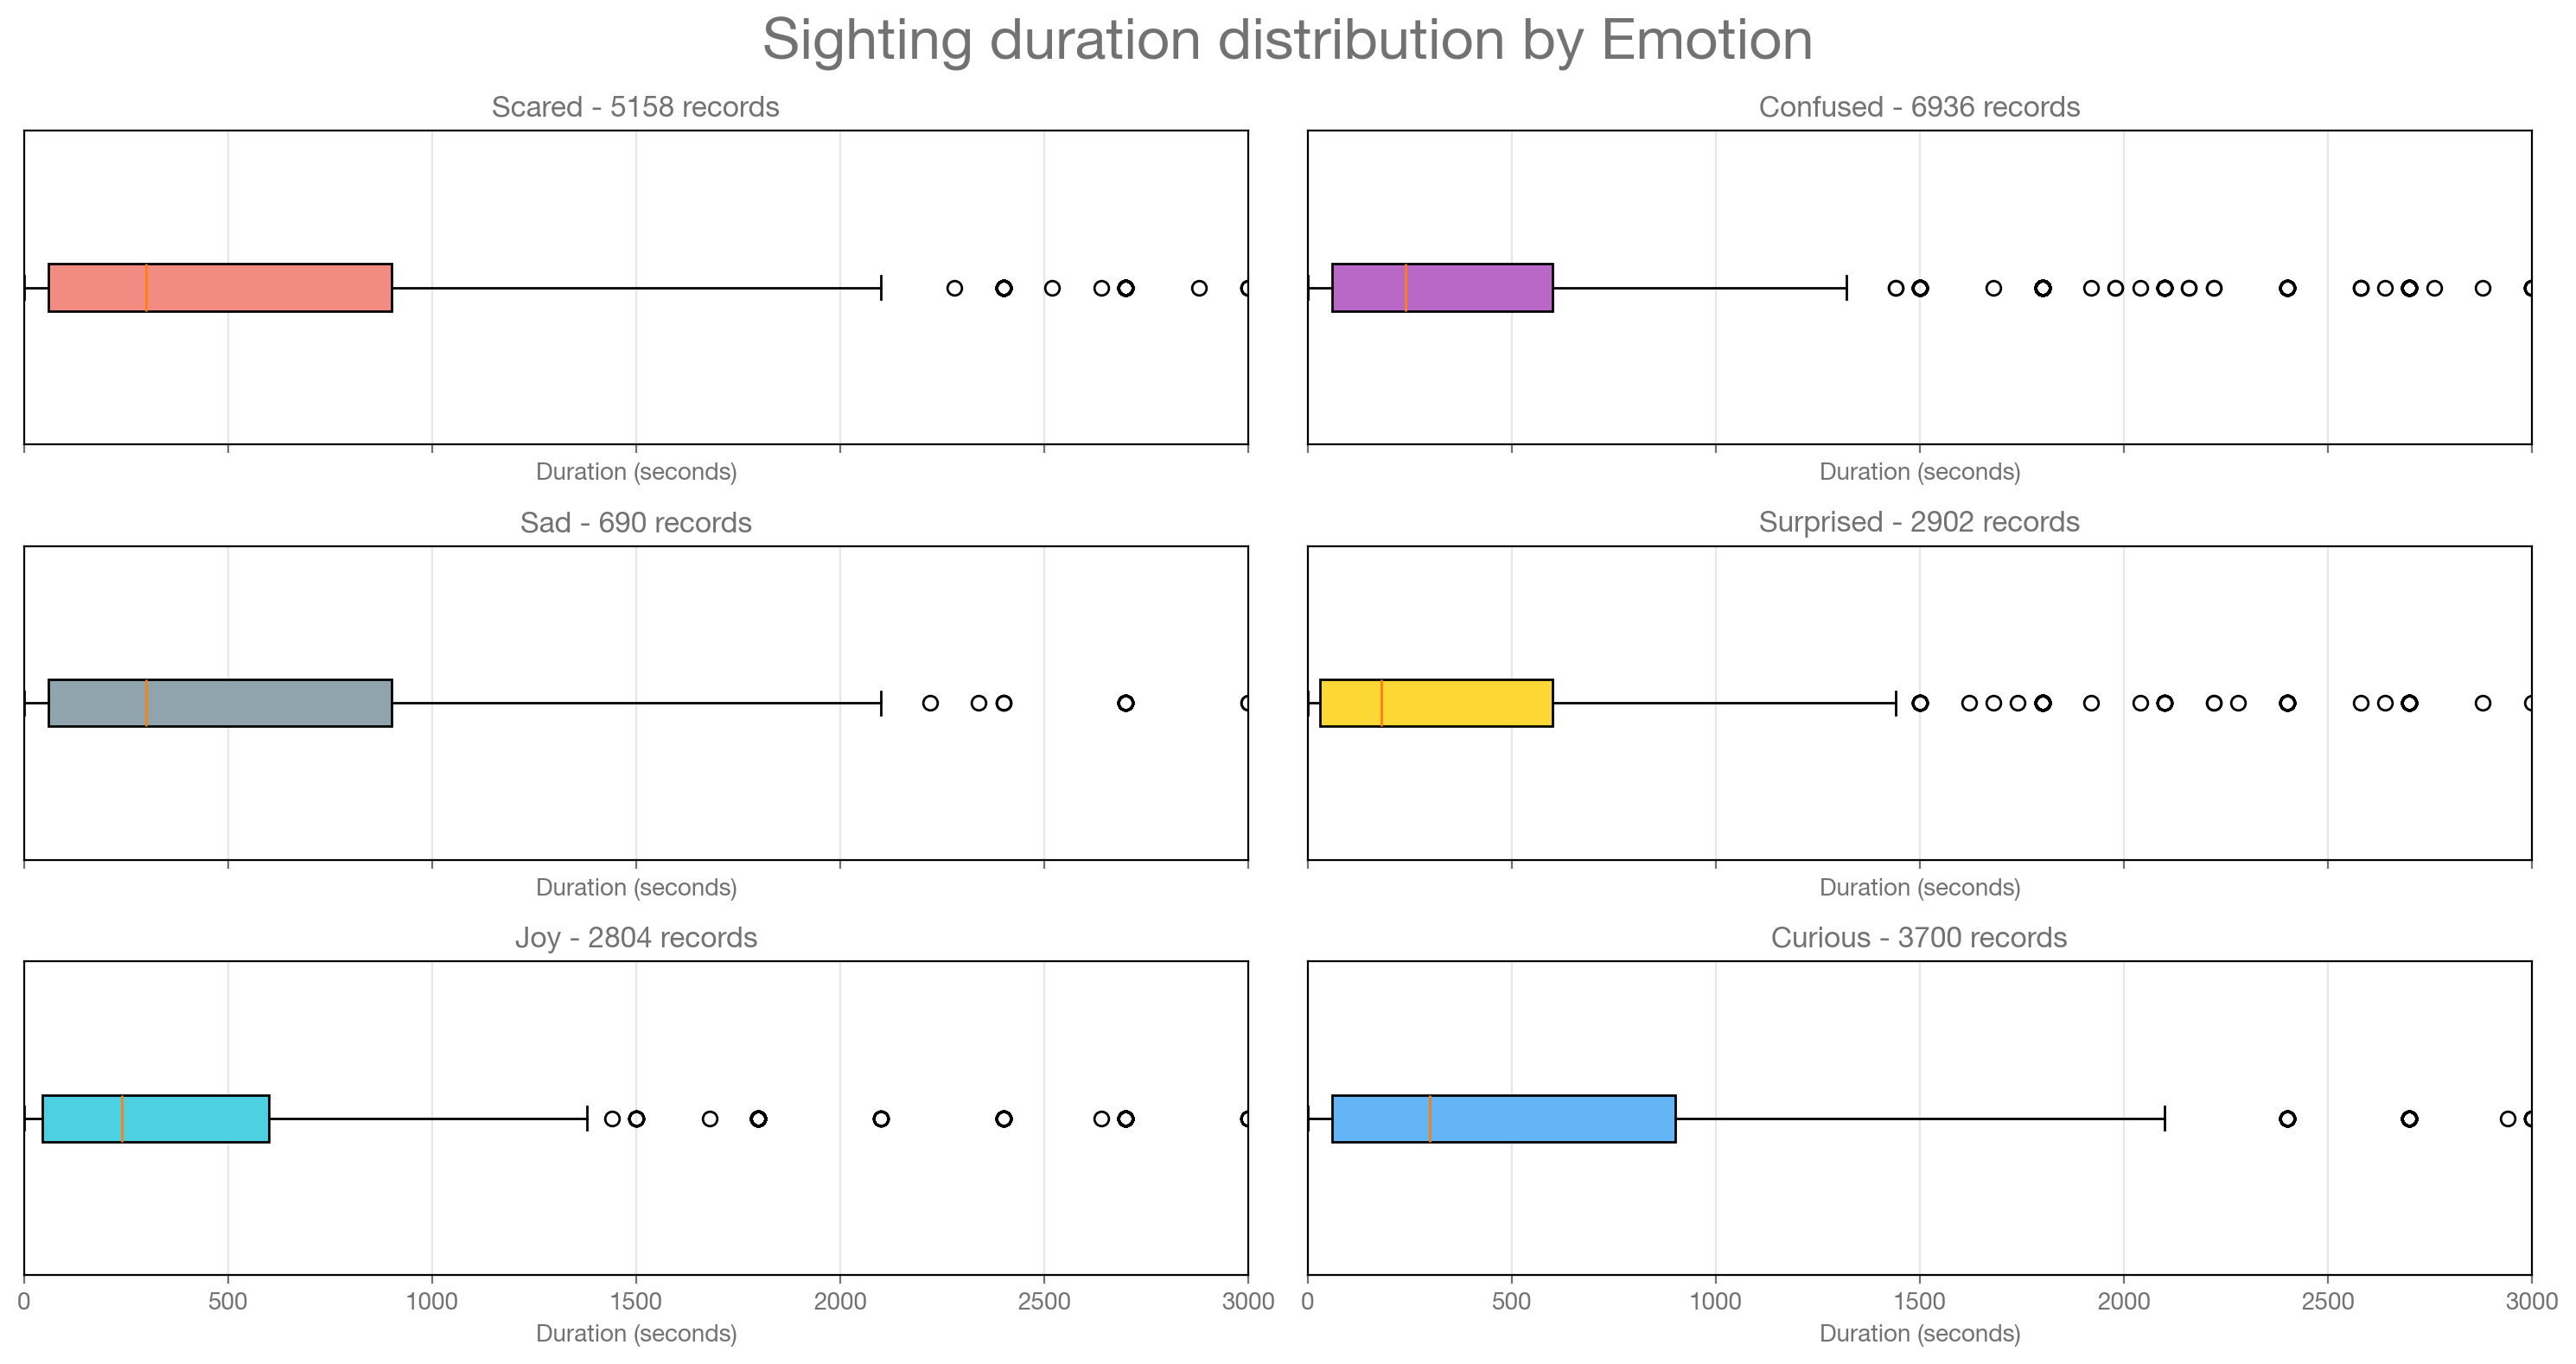

In [230]:
fig, axes = plt.subplots(3, 2, figsize=(15, 8), sharex=True)

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True].copy().dropna(subset=['duration'])

    ax.boxplot(
        df_emotion['duration'], 
        vert=False, 
        patch_artist=True, 
        boxprops=dict(facecolor=emotion_colors.get(e))
    )
    ax.set_title(f'{e.capitalize()} - {len(df_emotion)} records')
    ax.set_xlabel('Duration (seconds)')
    ax.set_xlim(0, 3000)  # Set x-axis limit for better visibility
    ax.set_yticks([])  # Remove y-axis ticks for clarity
    ax.grid(axis='x', alpha=0.3)  # Add grid lines for x-axis

fig.suptitle('Sighting duration distribution by Emotion', fontsize=24)
plt.tight_layout()
plt.savefig(output_path_plt + 'sightings_by_emotion_duration.png', bbox_inches='tight')

The longest average durations come from Scared. You can see it clearly in the position of the box — the upper quartiles are visibly higher than most others. Confused and Joy are among the shortest, with the box packed tightly near the start of the x-axis. This might indicate that these emotions are less persisting than the negative ones.

All of them are still most of the time confined between a bunch of seconds and less than 15 minutes.

Whiskers also tell a story: Curious and some others have long whiskers, meaning their durations vary a lot. Confused and Joy seem to follow the same trend as before, having much shorter whiskers: those emotions show up in more uniform, shorter sightings.

Confused also stands out when it comes to the concentration of outliers in the analyzed range of duration. They show a bunch of scattered dots after the right whisker, even though their core durations are short — looks like rare, long events push those emotions over the edge.

### Cited movies

In [231]:
df_movies = df_sent.loc[
    df_sent['comments'].str.contains('movie', na=False),
    'comments'
]

print('There are ' + str(len(df_movies)) + ' records with the word "movie"')

# Mapping of movie names to publish years
movie_years = {
    "Twister": 1996,
    "Predator": 1987,
    "Armageddon": 1998,
    "Star Wars": 1977,
    "A scene out of a Spielberg movie": '?',
    "Old movie of the UFOs in Montana in the late forties": 1950,
    "Star Trek": 1979,
    "UFO Unplugged": 1997,
    "Deep impact": 1998,
    "Close Encounters of the Third Kind": 1977,
    "Independence Day": 1996,
    "E.T.": 1982,
    "The Day the Earth Stood Still": 1951,
    "War of the Worlds": 2005,
    "X-Files": 1998,
    "Interstellar": 2014,
}

# Prepare a list to collect results
movie_rows = []
for idx, row in tqdm(df_sent.iterrows(), total=len(df_sent)):
    comment = row['comments']
    year = row['date posted'].year if pd.notnull(row['date posted']) else None
    for movie, release_year in movie_years.items():
        if re.search(rf'\b{re.escape(movie)}\b', comment, re.IGNORECASE):
            label = f"{movie} ({release_year})"
            movie_rows.append({
                'Row ID': idx,
                'Movie': label,
                'Year': year,
                'Comment': comment
            })

# Create DataFrame
df_movies = pd.DataFrame(movie_rows)
df_movies.set_index('Row ID', inplace=True)
df_movies.sort_values(by='Movie', inplace=True)

print('There are ' + str(len(df_movies)) + ' records referencing movie titles')

df_movies

There are 1630 records with the word "movie"


  0%|          | 0/130963 [00:00<?, ?it/s]

There are 642 records referencing movie titles


,Movie,Year,Comment
Row ID,,,
51595,A scene out of a Spielberg movie (?),2003,My interest stems from my knowledge and experi...
36424,Armageddon (1998),2023,2 lights were noticed together like Mars & a s...
99118,Armageddon (1998),2011,This article will give you some information ab...
42523,Armageddon (1998),1999,"My parents, and my son and I were driving down..."
114808,Close Encounters of the Third Kind (1977),2018,I was watching the stars and noticed one of th...
...,...,...,...
72340,X-Files (1998),2022,I was awaken approximately at 1 AM by a sound ...
68740,X-Files (1998),2003,at about 9:45pm i saw a light out in the dista...
60445,X-Files (1998),2012,"It had a circular, aqua colored top that appea..."


In [232]:
df_movies.groupby('Movie').size().sort_values(ascending=False).reset_index(name='Count')

,Movie,Count
0,Star Trek (1979),183
1,Star Wars (1977),163
2,Predator (1987),81
3,Independence Day (1996),67
4,Close Encounters of the Third Kind (1977),37
5,X-Files (1998),37
6,War of the Worlds (2005),24
7,Interstellar (2014),17
8,E.T. (1982),15
9,Twister (1996),6


### Year distribution of 'Star Wars' movie

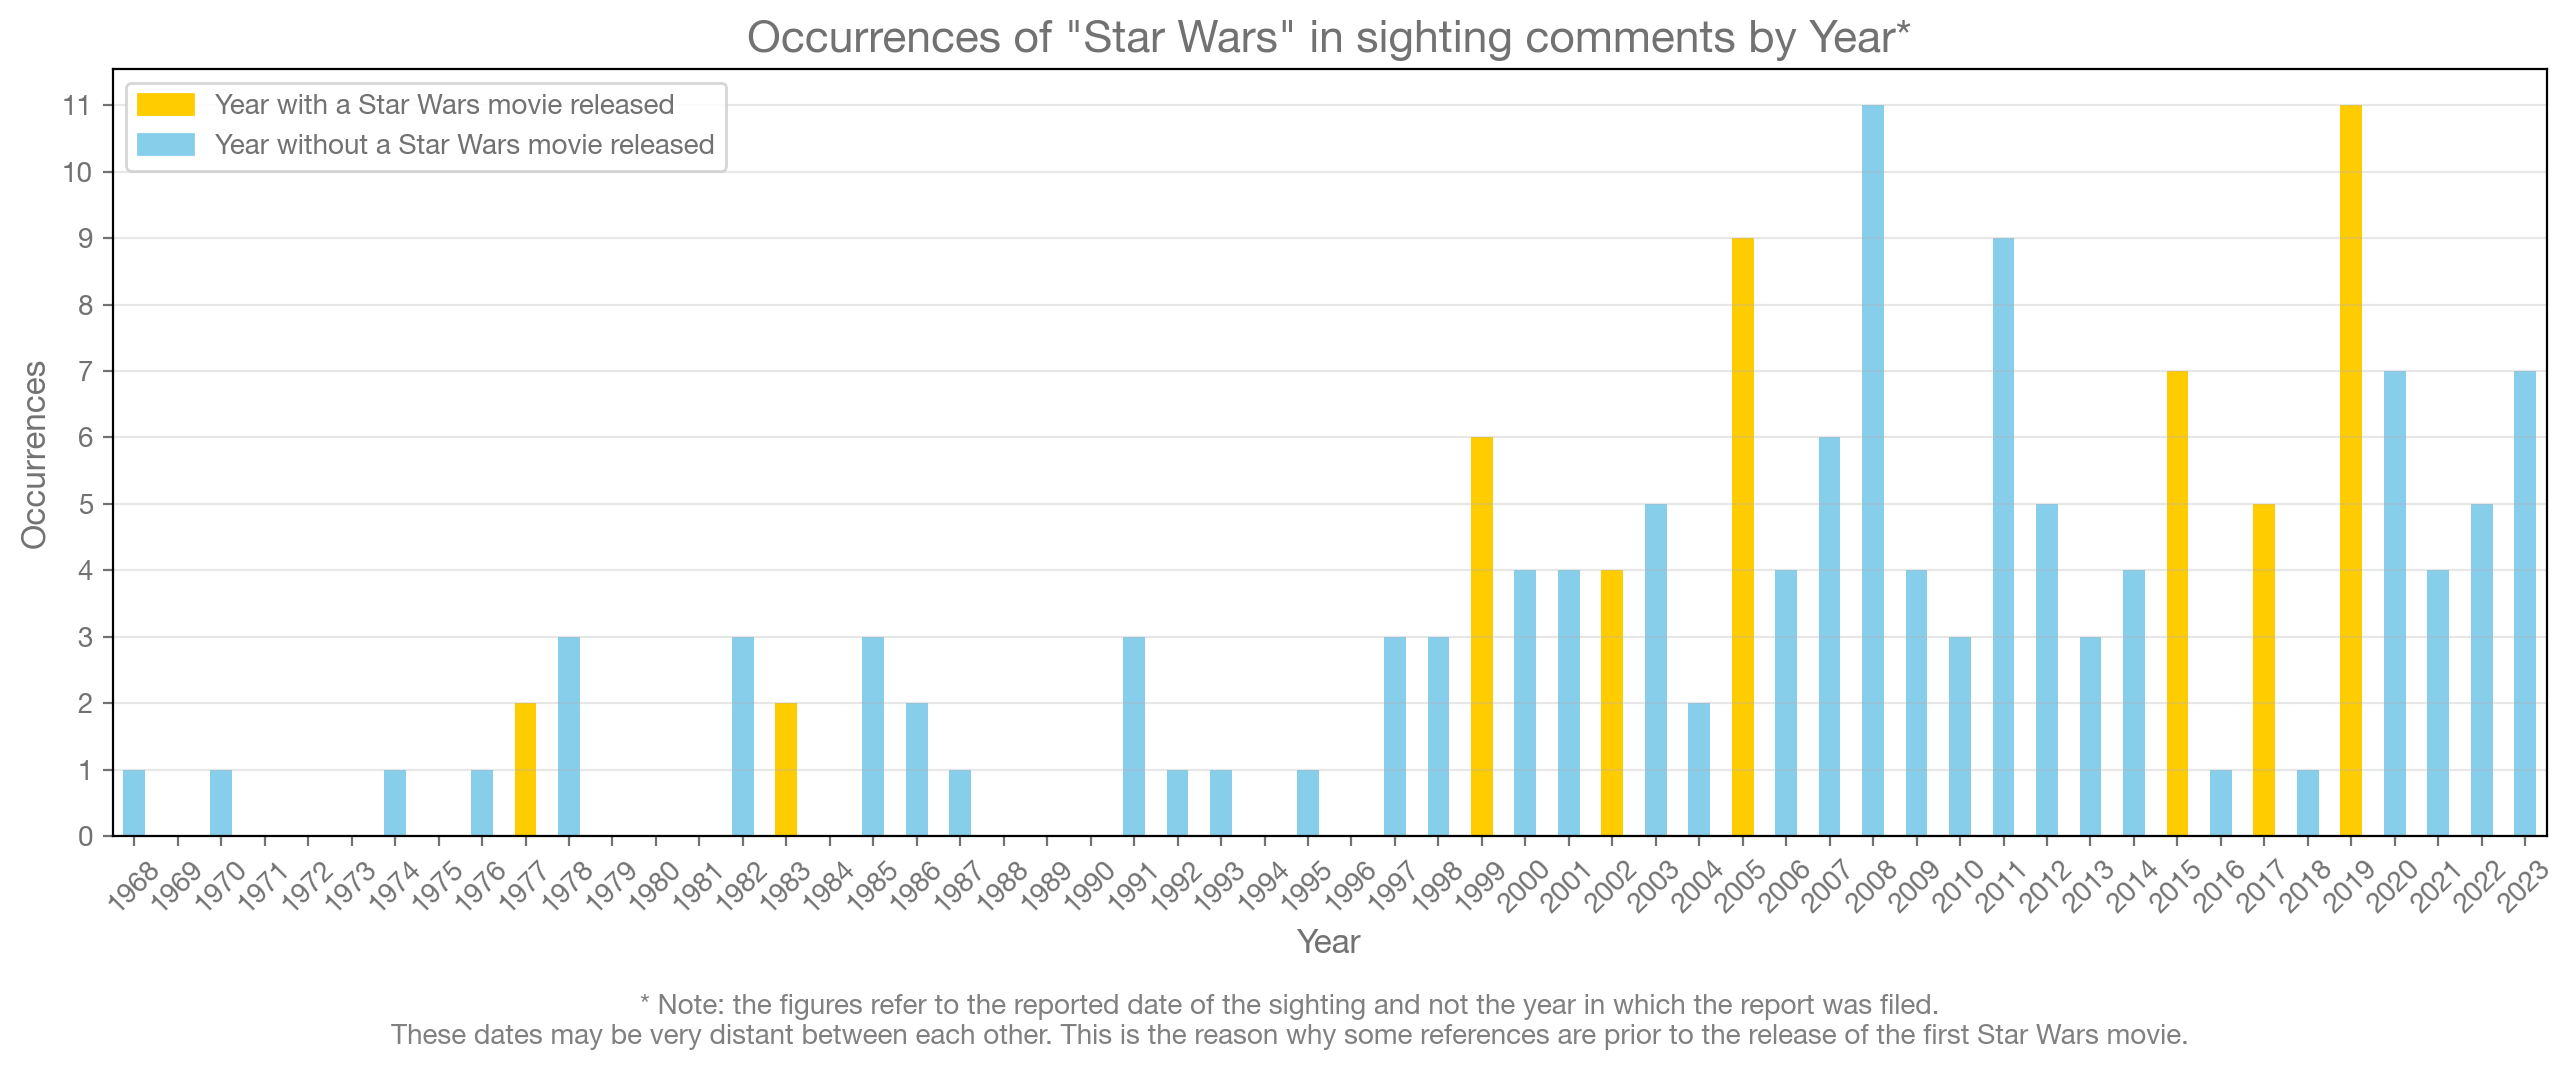

In [233]:
import matplotlib.patches as mpatches

df_star_wars = df_sent.loc[df_movies[df_movies['Movie'] == 'Star Wars (1977)'].index].copy()
star_wars_ref_by_year = (
    df_star_wars['datetime'].dt.year.value_counts()
    .reindex(np.arange(df_star_wars['datetime'].dt.year.min(), df_star_wars['datetime'].dt.year.max() + 1), fill_value=0)
    .sort_index()
)

# Define the years of Star Wars movie releases
star_wars_years = [1977, 1980, 1983, 1999, 2002, 2005, 2015, 2017, 2019]

# Assign colors to bars based on whether the year corresponds to a Star Wars movie release
colors = ['#ffcc00' if year in star_wars_years else 'skyblue' for year in star_wars_ref_by_year.index]

# Create a bar plot
plt.figure(figsize=(13, 5))
star_wars_ref_by_year.plot(kind='bar', color=colors)

release_patch = mpatches.Patch(color='#ffcc00', label='Year with a Star Wars movie released')
other_patch = mpatches.Patch(color='skyblue', label='Year without a Star Wars movie released')
plt.legend(handles=[release_patch, other_patch])

# Add notice about the years
plt.figtext(
    0.5, -0.05, 
    '* Note: the figures refer to the reported date of the sighting and not the year in which the report was filed.\n'
    'These dates may be very distant between each other. This is the reason why some references are prior to the release of the first Star Wars movie.',
    ha='center', fontsize=10, color='gray', wrap=True
)

plt.title('Occurrences of "Star Wars" in sighting comments by Year*', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Occurrences', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.yticks(range(0, star_wars_ref_by_year.max() + 1))
plt.xticks(ticks=range(len(star_wars_ref_by_year.index)), labels=star_wars_ref_by_year.index, rotation=45)
plt.tight_layout()
plt.savefig(output_path_plt + 'sightings_by_star_wars_years.png', bbox_inches='tight')

From the plot, it is evident that, apart from the first two movies, sightings consistently peak around the release of new Star Wars movies. For instance, between 2014 and 2020, sightings rose and fell in sync with the release of three Star Wars films. While this could be coincidental, the references in the comments suggest that the movies may have influenced the reports.
It must be noted that the data shown reflects the stated date of the sighting, not the date in which it was posted. That's the reason why it is also referenced for sightings before the release of the first movie.

## Discussion

6. Discussion
   - Think critically about your creation
   - What went well?
   - What is still missing? What could be improved? Why?

# Contributions
> You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain). It is not OK simply to write "All group members contributed equally".

We worked together on the exercises during class and then collaborated closely, contributing equally to the final project. We all have a consolidated understanding of all parts of the project. At the same time, we decided to split the responsibilities for the different parts of it, in terms of writing the code and the text for the website. The following table shows the distribution of the said responsibilities: 

| Student              | Main Responsibility           |
| ---------------------|-------------------------------|
| Ludovico Cappellato  | Part 1                        |
| Francesco Balducci   | Part 2                        |
| Maja Klerk           | Part 3                        |